# Прогнозирование количества заказов такси на следующий час
Компания агрегатор заказов такси планирует привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
## Цель. 
Построить модель предсказания количества заказов такси на следующий час, метрика RMSE должна быть не более 48.
## План работы.
1. Загрузка и ресемплирование данных.  
2. Анализ данных
3. Подготовка данных
4. Построение моделей и выбор лучшей.
5. Тестирование лучшей модели и формулирование выводов.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder)
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Загрузка и ресемплирование данных

In [2]:
# Загрузка датасетов (перед публикацией сетевой путь удален по просьбе обучающей платформы)
try:
    df = pd.read_csv('taxi.csv', sep=',', index_col=[0], parse_dates=True)
except:
    df = pd.read_csv('taxi.csv', sep=',', index_col=[0], parse_dates=True)

df.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
df.shape

(26496, 1)

In [6]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
display(df.head(3))
df.tail(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


,num_orders
datetime,
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Имеем данные с марта по август 2018 года.

## Анализ данных

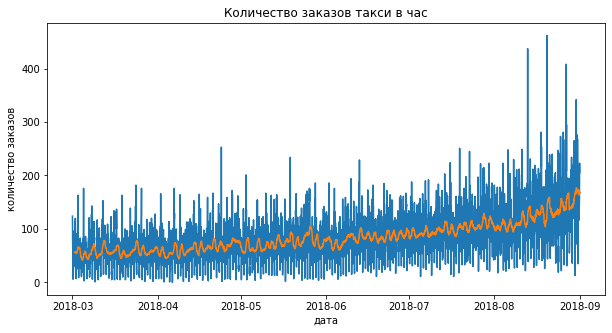

In [7]:
df['rolling_mean'] = df.rolling(24).mean()
plt.figure(figsize=(10,5))
plt.plot(df)
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('Количество заказов такси в час')

df.drop(columns='rolling_mean', axis=1, inplace=True)

Среднее и дисперсия увеличиватся. Временной ряд не является стационарным.

In [9]:
# Тест Фуллера
adf = adfuller(df.num_orders)
print(f'adf: {round(adf[0], 2)} \np-value: {round(adf[1], 4)}  \
        \nКритические значения: {adf[4]} ')

adf: -3.07 
p-value: 0.0289          
Критические значения: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452} 


In [10]:
# Декомпозиция
decomp = seasonal_decompose(df)

Text(0.5, 1.0, 'Тренд')

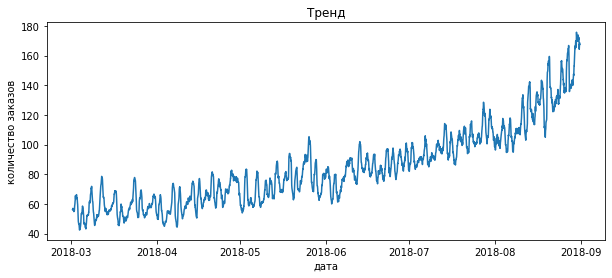

In [11]:
# Строим график тренда
plt.figure(figsize=(10,4))
plt.plot(decomp.trend)
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('Тренд')

Видим восходящий тренд

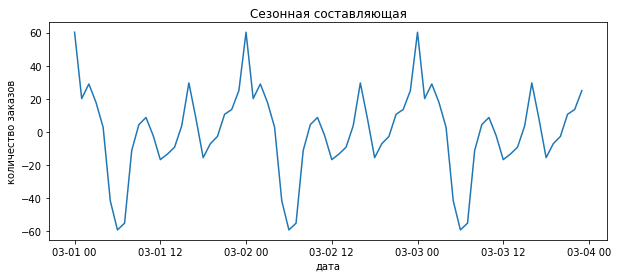

In [12]:
# Строим график сезонной составляющей
plt.figure(figsize=(10,4))
plt.plot(decomp.seasonal['2018-03-01':'2018-03-03'])
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('Сезонная составляющая')
plt.show();

Видим пик заказов в 12:00 ночи, а минимум в районе 6:00 утра.

Text(0.5, 1.0, 'Остатки')

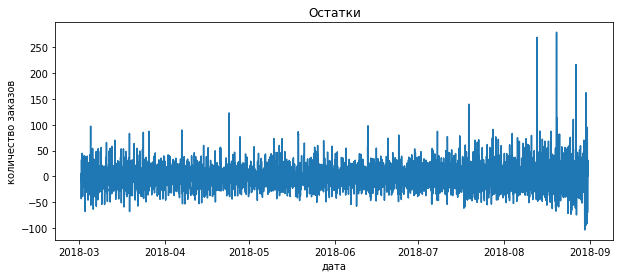

In [13]:
# Строим график остатков
plt.figure(figsize=(10,4))
plt.plot(decomp.resid)
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('Остатки')

In [14]:
# Создаем признаки
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data.num_orders.shift(1).rolling(rolling_mean_size).mean()

Не стал включать месяц в число признаков, т.к. обучающая выборка не за полный год и в сентябре для модели появится неизвестное значение месяца. 

In [15]:
# сдвиги возьмем 24 - т.е. максимально на сутки. Среднюю возьмем за 10 дней.
make_features(df, 168, 240)
df.head(3)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# удалим строки с возникшими пропусками
df.dropna(inplace=True)
df.head(3)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-11 00:00:00,81,11,6,73.0,80.0,62.0,54.0,33.0,102.0,60.0,...,39.0,12.0,11.0,22.0,27.0,42.0,26.0,60.0,75.0,54.633333
2018-03-11 01:00:00,83,11,6,81.0,73.0,80.0,62.0,54.0,33.0,102.0,...,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,60.0,54.454167
2018-03-11 02:00:00,36,11,6,83.0,81.0,73.0,80.0,62.0,54.0,33.0,...,19.0,39.0,39.0,12.0,11.0,22.0,27.0,42.0,26.0,54.445833


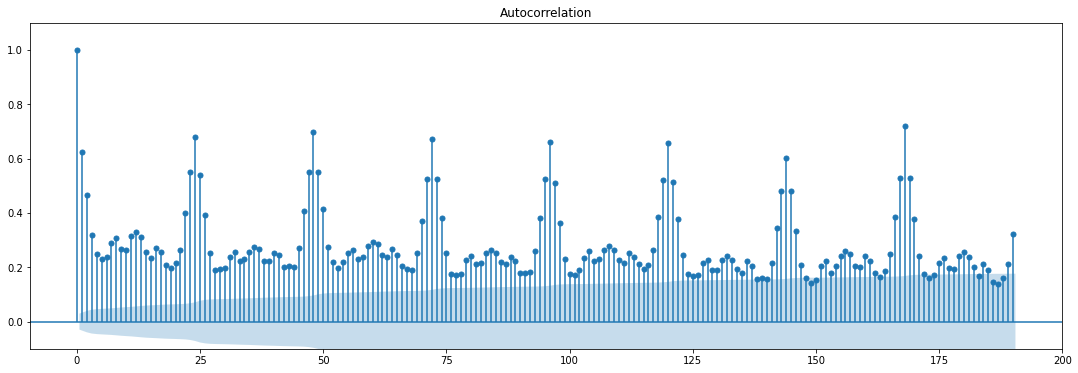

In [16]:
# Авкорреляция
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']
fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

С таргетом сильно коррелирует сдвиги, кратные 24 периода и сдвиг на 1 период (час).

## Подготовка данных

In [18]:
# Определим константы
RANDOM_STATE = 42

# Определим X и y
X = df.drop('num_orders', axis=1)
y = df['num_orders']

# Выделим тренировочную и тестовую выборки
Х_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [19]:
# создаем списки переменных
# категориальные
cat_col = ['day', 'dayofweek']
# числовые
num_col = list(set(Х_train.select_dtypes(include='number').columns) - set(cat_col))

print(f'Числовые: {num_col} \nКатегориальные: {cat_col}' )

Числовые: ['lag_165', 'lag_7', 'lag_27', 'lag_88', 'lag_99', 'lag_35', 'lag_126', 'lag_141', 'lag_12', 'lag_123', 'lag_114', 'lag_46', 'lag_103', 'lag_74', 'lag_156', 'lag_14', 'lag_150', 'lag_112', 'lag_110', 'lag_67', 'lag_102', 'lag_6', 'lag_158', 'lag_140', 'lag_43', 'lag_117', 'lag_136', 'lag_93', 'lag_40', 'lag_91', 'lag_96', 'lag_70', 'lag_90', 'lag_83', 'lag_163', 'lag_157', 'lag_132', 'lag_42', 'lag_151', 'lag_72', 'lag_146', 'lag_39', 'lag_98', 'lag_58', 'lag_152', 'lag_8', 'lag_69', 'lag_61', 'lag_80', 'lag_100', 'lag_130', 'lag_22', 'lag_31', 'lag_19', 'lag_54', 'lag_127', 'lag_118', 'lag_62', 'lag_24', 'lag_45', 'lag_11', 'lag_52', 'lag_161', 'lag_15', 'lag_155', 'lag_79', 'lag_121', 'lag_124', 'lag_28', 'lag_134', 'lag_49', 'lag_162', 'lag_32', 'lag_63', 'lag_149', 'lag_167', 'lag_84', 'lag_109', 'lag_34', 'lag_133', 'lag_120', 'lag_147', 'lag_29', 'lag_1', 'lag_17', 'lag_44', 'lag_20', 'lag_3', 'lag_168', 'lag_56', 'lag_75', 'lag_106', 'lag_131', 'lag_144', 'lag_113', 'l

## Обучение моделей

Для решения задачи регрессии можем взять линейную регрессию как самую базовую (все параметры числовые), дерево-регрессор и модель градиентного бустинга.

In [20]:
# кодирование категориальных переменных
ohe_pipe = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', MinMaxScaler(), num_col)
    ],
    remainder='passthrough'
)

# подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [21]:
tscv = TimeSeriesSplit(n_splits=4)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(Х_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['da...
                                                                                'lag_112',
                                                                                'lag_110',
                                                                                'lag_67',
                                                                                'lag_102',
                                                                                'lag_6',
                                                                                'lag_158',
                                                                                'lag_140',
                                                                                'lag_43',
                                                                                'lag_117',
                                                                                'lag_136',
                                                                                'lag_93',
                                                                                'lag_40',
                                                                                'lag_91', ...])])),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [22]:
model_lr = randomized_search.best_estimator_
print(round(root_mean_squared_error(model_lr.predict(Х_train), y_train),2))

20.28


In [23]:
# Дерево решений и бустинг
# кодирование категориальных переменных
ord_pipe = Pipeline(
    [
        ('imputer_before_ord',
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

        ('ord',
         OrdinalEncoder(
             handle_unknown='use_encoded_value',
             unknown_value=np.nan,
             categories='auto'
            )
        ),
        (
            'imputer_after_ord',
             SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]

)

# подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_col)
    ],
    remainder='passthrough'
)

# подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для дерева решений
    {
        'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 50),
        'models__min_samples_leaf': range(2, 10),
        'models__max_leaf_nodes': range(100, 500)
    },

    # словарь для бустинга
    {
        'models':[LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
        'models__n_estimators': [10, 50, 100],
        'models__num_leaves':range(100, 500)
    }
]

In [24]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(Х_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('imputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)...
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 50),
                                         'models__max_leaf_nodes': range(100, 500),
                                         'models__min_samples_leaf': range(2, 10)},
                                        {'models': [LGBMRegressor(random_state=42,
                                                                  verbose=-1)],
                                         'models__n_estimators': [10, 50, 100],
                                         'models__num_leaves': range(100, 500)}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [25]:
model = randomized_search.best_estimator_
print(round(root_mean_squared_error(model.predict(Х_train), y_train),2))

16.16


И линейная регрессия, и дерево удовлетворяют критерию rmse<48. Возмьем линейную регрессию, как более простую и надежную, и, кроме того, способную предсказывать за пределами диапазона обучающих данных.

## Тестирование лучшей модели и формулирование выводов.

In [26]:
pred_model_const = y_test.shift(1, fill_value=0)
print('rmse на константнй модели ', round(root_mean_squared_error(pred_model_const, y_test)),
      '\nrmse на модели линейной регрессии', round(root_mean_squared_error(model_lr.predict(X_test), y_test)))

rmse на константнй модели  59 
rmse на модели линейной регрессии 35


На тестовой выборке rmse по-прежнему менее порогового 48. В сравнении с константой моделью точность нашей модели очевидно выше. Цель достигнута.

## Выводы
Обучены модели линейной регрессии, дерево решений, градиентный бустинг (LGBM). Выбрана модель на основе линейной регрессии как более простая и надежная, а также способная предсказывать за пределами диапазона обучающих данных. Модель показала метрику качества RMSE=20, что соответствует требованию заказчика. Эффективность модели также доказана сравнением с константной моделью.